In [40]:
import numpy as np
import matplotlib.pyplot as pl
import time
from joblib import Parallel, delayed

In [41]:
c = 3e8
G = 6.67e-11
pi = np.pi
const = 96/5*pi**(8/3)*(G/c**3)**(5/3)

Specific arguments

In [42]:
f0 = 120
Mc = 3e-4* 2e30
f_max = 200
T_obs = 1e4
pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
beta = const*f0**(8/3)*Mc**(5/3)

f_signal = 40*f_max
nt = round(f_signal*T_obs)
t = np.arange(nt)/f_signal
f_ratio = 25

In [43]:
beta

2.7439303219997145e-07

Generating signal and adding noise

In [44]:
phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [50]:
# add real Gaussian noise and take real phase
# correct with known exact beta
# with some offsets

In [9]:
%reset_selective -f "^signal$"
%reset_selective -f noise
%reset_selective -f phi

In [10]:
def strobo(beta, data, f_ratio):
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    f_new = f_signal/f_ratio
    
    new_t *= f_new #changes the frequency to the new downsampled frequency (approximately, not exactly)
    floor_t = np.floor(new_t) #For some reason floor works better than round. Take it to the nearest time index which are integers
    idx = np.nonzero(np.diff(floor_t)) #The step that downsamples
    resampled = data[idx]
    t_out = (new_t[idx]-new_t[0])/f_new
    return (resampled, t_out)

In [11]:
# f_ratio = 25
# out, t_out = strobo(beta, data, f_ratio)
# corrected = np.fft.fftshift(np.fft.fft(out))
# freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(t_out), d=t_out[1]-t_out[0]))
# corrected = corrected[len(corrected)//2:]
# resampled_power = np.abs(corrected/len(out))**2

# freq_corrected = freq_corrected[len(freq_corrected)//2:]
# nt_new = len(out)

In [12]:
# pl.plot(freq_corrected, np.abs(resampled_power), 'o')
# pl.xlim(119.995, 120.005)

In [13]:
# (pad_len - len(out)) / pad_len

In [15]:
# len(out)

## Padding the data

In [16]:
def pad_calc(beta):
#     print(pad_len)
    new_t = -3/5*(1-8/3*beta*t)**(5/8)/beta
    out, t_out = strobo(beta, data, f_ratio)
    pad_frac = (pad_len - len(out)) / len(out)
    padded = np.full(pad_len, 0, dtype = complex)
    padded[:len(out)] = out
    pad_corrected = np.fft.fftshift(np.fft.fft(padded))
    pad_freq_corrected = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
    pad_resampled_power = np.abs(pad_corrected/len(padded))**2
    
    arg_max = np.argmax(pad_resampled_power)
    peak_freq = pad_freq_corrected[arg_max]
    peak_power = pad_resampled_power[arg_max]
    return np.array([peak_freq, peak_power, pad_frac])

In [21]:
pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
pad_calc(beta+1e-4*beta)

array([1.20000014e+02, 8.90342719e-01, 9.23540900e-03])

In [22]:
pad_len = int(334.4*T_obs) #~0.01 added length to resampled data
pad_calc(beta+1e-4*beta)

array([1.20000014e+02, 8.32730948e-01, 4.35631440e-02])

In [23]:
%reset_selective -f new_t
%reset_selective -f padded
%reset_selective -f phi

In [24]:
tic = time.time()

pad_len = int(323.4*T_obs) #~0.01 added length to resampled data
pad_len_0 = pad_len
offset_arr = np.logspace(-8, -1, 100)
ref_freq_0, ref_power_0, _ = pad_calc(beta)

result_0 = np.array(Parallel(4)(delayed(pad_calc)(beta+i*beta) for i in offset_arr))
toc = time.time()
print((toc-tic)/60)

2.4841712633768718


In [25]:
tic = time.time()

pad_len = int(502.4*T_obs) #~0.01 added length to resampled data
pad_len_1 = pad_len
offset_arr = np.logspace(-8, -1, 100)
ref_freq_1, ref_power_1, _ = pad_calc(beta)

result_1 = np.array(Parallel(4)(delayed(pad_calc)(beta+i*beta) for i in offset_arr))
toc = time.time()
print((toc-tic)/60)

2.98727068901062


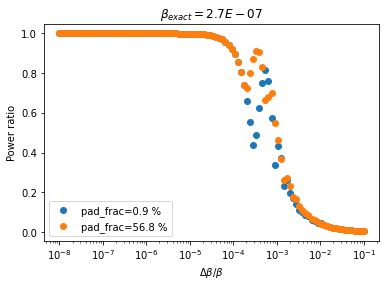

In [26]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, result_0[:,1]/ref_power_0, 'o', label = 'pad_frac=%.1F %%' % (100*result_0[0,2]))
pl.semilogx(offset_arr, result_1[:,1]/ref_power_1, 'o', label = 'pad_frac=%.1F %%' % (100*result_1[0,2]))
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.legend()
# pl.axvline(offset_arr[-40])
pl.show()

## Inspecting the FFTs before and after bump

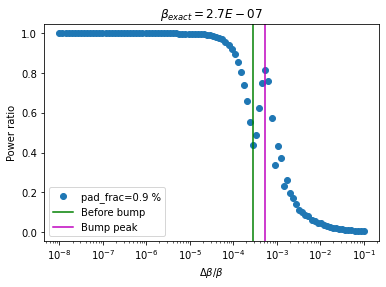

In [27]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, result_0[:,1]/ref_power_0, 'o', label = 'pad_frac=%.1F %%' % (100*result_0[0,2]))
# pl.semilogx(offset_arr, result_1[:,1]/ref_power_1, 'o', label = 'pad_frac=%.1F %%' % (100*result_1[0,2]))
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$' % beta)
pl.axvline(offset_arr[-37], c='g', label="Before bump")
pl.axvline(offset_arr[-33], c='m', label="Bump peak")
pl.legend()
pl.show()

In [47]:
temp_beta = (1+offset_arr[-37])*beta
new_t = -3/5*(1-8/3*temp_beta*t)**(5/8)/temp_beta
out, t_out = strobo(temp_beta, data, f_ratio)
padded = np.full(pad_len, 0, dtype = complex)
padded[:len(out)] = out
pad_corrected = np.fft.fftshift(np.fft.fft(padded))
pad_freq_corrected_0 = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
pad_resampled_power_0 = np.abs(pad_corrected/len(padded))**2

temp_beta = (1+offset_arr[-33])*beta
new_t = -3/5*(1-8/3*temp_beta*t)**(5/8)/temp_beta
out, t_out = strobo(temp_beta, data, f_ratio)
padded = np.full(pad_len, 0, dtype = complex)
padded[:len(out)] = out
pad_corrected = np.fft.fftshift(np.fft.fft(padded))
pad_freq_corrected_1 = np.fft.fftshift(np.fft.fftfreq(len(padded), d=t_out[1]-t_out[0]))
pad_resampled_power_1 = np.abs(pad_corrected/len(padded))**2

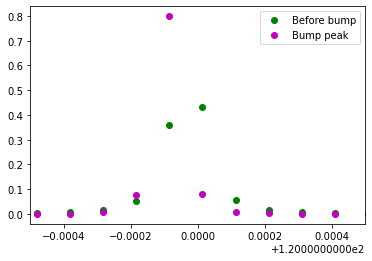

In [49]:
pl.plot(pad_freq_corrected_0, pad_resampled_power_0, 'go', label = 'Before bump')
pl.plot(pad_freq_corrected_1, pad_resampled_power_1, 'mo', label = 'Bump peak')
pl.xlim(119.9995, 120.0005)
pl.legend()

In [ ]:
# Conclusion: Does seem to be caused by moving between bins

## Changing T_obs

In [35]:
T_obs_1 = 1e3
nt = round(f_signal*T_obs_1)
t = np.arange(nt)/f_signal

phi = -6*pi/5*f0*(1-8./3.*beta*t)**(5/8)/beta
phi = np.mod(phi,2*pi)
signal = 1*np.exp(1j*phi)

nh = 0
noise = nh*np.random.normal(size = nt)
data = signal + noise

In [33]:
tic = time.time()

pad_len = int(323.4*T_obs)
pad_len_2 = pad_len
offset_arr = np.logspace(-8, -1, 100)
ref_freq_2, ref_power_2, _ = pad_calc(beta)

result_2 = np.array(Parallel(4)(delayed(pad_calc)(beta+i*beta) for i in offset_arr))
toc = time.time()
print((toc-tic)/60)

0.24160919189453126


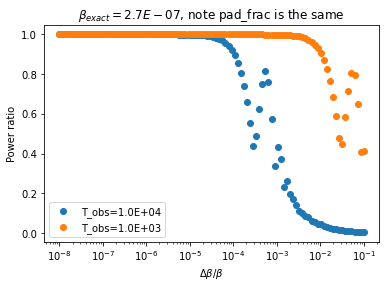

In [37]:
# pl.plot(offset_arr, offset_results[:,0]/ref_freq)
# pl.show()
pl.semilogx(offset_arr, result_0[:,1]/ref_power_0, 'o', label = 'T_obs=%.1E' % T_obs)
pl.semilogx(offset_arr, result_2[:,1]/ref_power_2, 'o', label = 'T_obs=%.1E' % T_obs_1)
pl.xlabel(r'$\Delta \beta / \beta$')
pl.ylabel('Power ratio')
pl.title(r'$\beta_{exact} = %.1E$, note pad_frac is the same' % beta)
pl.legend()
# pl.axvline(offset_arr[-40])
pl.show()